In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import numpy as np
import seaborn as sns
import pandas as pd
import os

In [51]:
#Now to download the data quality from the COADDS (SN_STATUS)

qual = pd.read_csv('sn_status.txt', sep=" ", header=None)
qual.columns = ["a", "NITE", "FIELD", "BAND", "ATT", "EXPNUM", "STATUS", "PSF",  
                "AIR", "FAKE", "zPSF", "SNR20", "EFF50", "ACCEPT"]

#Update so we're only looking at first three years
qual = qual.query('NITE > 20130606 and NITE < 20160606')

#Get rid of fact that the table seems to double-count some filter-fields; these are in SN_STATUS with no BAND entry
qual = qual[~qual['BAND'].isnull()]

In [52]:
#Store in array 't' those exposures which passed Data Quality cuts.
print 'Total filter-epochs: ', len(qual)

t = qual.query("ACCEPT == 'True'")
print 'Total good filter-epochs: ', len(t)
print '---'

print 'Total DEEP filter-epochs: ', len(qual.query("FIELD == 'SN-C3' or FIELD == 'SN-X3'"))
print 'Total good DEEP filter-epochs: ', len(t.query("FIELD == 'SN-C3' or FIELD == 'SN-X3'"))

Total filter-epochs:  3179
Total good filter-epochs:  2663
---
Total DEEP filter-epochs:  569
Total good DEEP filter-epochs:  500


In [53]:
#Percent of Shallow Field exposures that fail: 447/2610 = 17%
#Percent of Deep Field exposures that fail:  69/569 = 12%

In [54]:
print qual.columns

Index([u'a', u'NITE', u'FIELD', u'BAND', u'ATT', u'EXPNUM', u'STATUS', u'PSF',
       u'AIR', u'FAKE', u'zPSF', u'SNR20', u'EFF50', u'ACCEPT'],
      dtype='object')


In [55]:
new_data = qual

#alldata = alldata.query("FIT != 0")
#print 'Length of all entries matched to only actual data: ',len(alldata)

#Remove the fields that have XXXX placeholders in the photometry file from the left join 
#alldata = alldata[alldata.FIELD != 'XXXX']
#print len(alldata)

In [56]:
new_data.columns

Index([u'a', u'NITE', u'FIELD', u'BAND', u'ATT', u'EXPNUM', u'STATUS', u'PSF',
       u'AIR', u'FAKE', u'zPSF', u'SNR20', u'EFF50', u'ACCEPT'],
      dtype='object')

<type 'numpy.ndarray'>
2663


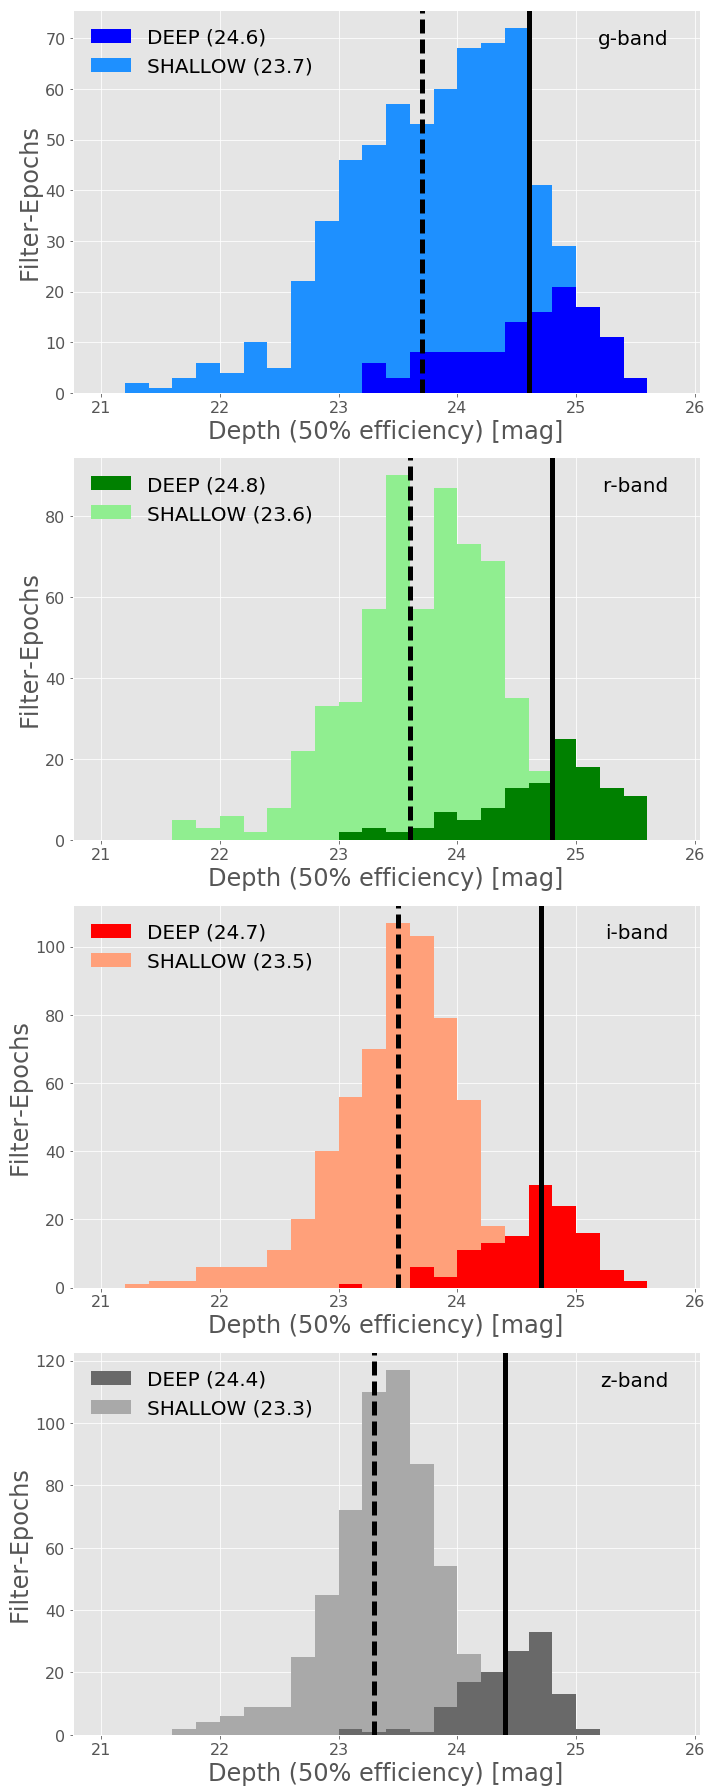

In [57]:
#PLOT FOR PAPER:  Histogram of Depth by field
f, ax1 = plt.subplots(4,1, figsize=(10,25))
ax2 = ax1.flatten()
mpl.style.use('ggplot')

print type(ax2)

t2 = new_data.query("ACCEPT == 'True'")
print len(t2)
deep    = t2.query("FIELD == 'SN-X3' or FIELD == 'SN-C3'")
shallow = t2.query("FIELD != 'SN-X3' and FIELD != 'SN-C3'")

color1  = ['blue', 'green', 'red', 'dimgrey']
color2  = ['dodgerblue', 'lightgreen', 'lightsalmon', 'darkgrey']
band = ['g', 'r', 'i', 'z']

for i,ax in enumerate(ax2):
    flt = band[i]
    
    t1 = shallow.query("BAND == '{0}'".format(flt))
    t2 = deep.query("BAND == '{0}'".format(flt))
    
    ax.hist([t2['EFF50'], t1['EFF50']], \
            bins=np.arange(21,26,0.2), color=[color1[i],color2[i]], \
            label=['DEEP ({0})'.format(t2['EFF50'].median()),'SHALLOW ({0})'.format(t1['EFF50'].median())], \
            stacked='True', width=0.2) 

    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.set_ylabel('Filter-Epochs',fontsize=24)
    ax.set_xlabel('Depth (50% efficiency) [mag]',fontsize=24)

    aa = ax.get_ylim()
    ax.plot(t2['EFF50'].median()*np.ones(100), np.linspace(aa[0],aa[1],100), linestyle='solid', color='black')
    ax.plot(t1['EFF50'].median()*np.ones(100), np.linspace(aa[0],aa[1],100), linestyle='dashed', color='black')
    ax.set_ylim(aa)
        
    ax.legend(loc='upper left',frameon=False,fontsize=20)
    ax.text(0.95,0.95,'{0}-band'.format(flt),fontsize=20,ha='right',va='top',transform = ax.transAxes)

#f.savefig('DES-SN3_DepthHist.pdf', format='pdf', bbox_inches='tight')
#plt.close()

plt.tight_layout()
plt.show()

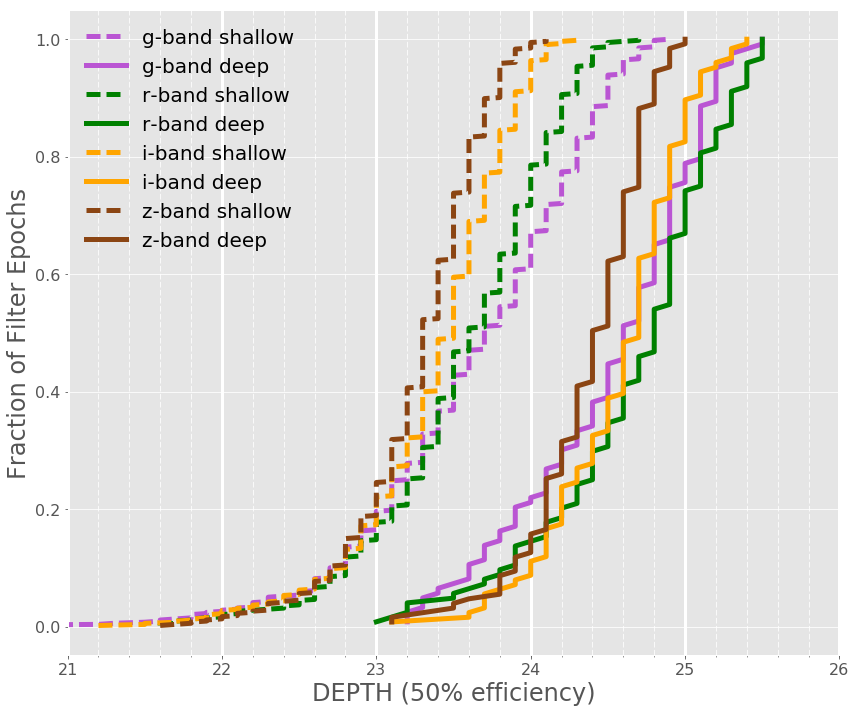

In [58]:
#PLOT FOR PAPER:  CDF of Depth by field
f, ax1 = plt.subplots(1, figsize=(12,10))

band   = ['g', 'r', 'i', 'z']
colors = ['mediumorchid','green','orange','saddlebrown']

mpl.rcParams['lines.linewidth'] = 5
t2 = new_data.query("ACCEPT == 'True'")

for i,item in enumerate(band):
    flt = item
    
    t1 = shallow.query("BAND == '{0}'".format(flt))
    t2 = deep.query("BAND == '{0}'".format(flt))
    
    x1 = t1.sort_values(by='EFF50')
    y1 = 1.0+np.arange(1.0*len(x1))
    ax1.plot(x1['EFF50'],y1/len(x1),color=colors[i],linestyle='dashed',label = '{0}-band shallow'.format(flt))
        
    x2 = t2.sort_values(by='EFF50')
    y2 = 1.0+np.arange(1.0*len(x2))    
    ax1.plot(x2['EFF50'],y2/len(x2),color=colors[i],linestyle='solid',label = '{0}-band deep'.format(flt))
        

    ax.tick_params(axis='both', which='major', labelsize=16)

    xminorLocator = MultipleLocator(0.2)
    #ax1.xaxis.set_major_locator(xmajorLocator)
    #ax1.xaxis.set_major_formatter(xmajorFormatter)
    ax1.xaxis.set_minor_locator(xminorLocator)
    ax1.grid(which='minor', axis='x', linestyle='--')
    ax1.grid(which='major', axis='x', linestyle='-',linewidth=3)

    #yminorLocator = AutoMinorLocator()
    #ax1.yaxis.set_minor_locator(yminorLocator)
    ax1.tick_params(axis='both', which='major', labelsize=16)

    
    ax1.set_ylabel('Fraction of Filter Epochs',fontsize=24)
    ax1.set_xlabel('DEPTH (50% efficiency)',fontsize=24)

    ax1.set_xlim(21,26)
    
    ax1.legend(loc='upper left',frameon=False,fontsize=20)
  
#f.savefig('DES-SN3_DepthCDF.pdf', format='pdf', bbox_inches='tight')
#plt.close()
plt.tight_layout()
plt.show()

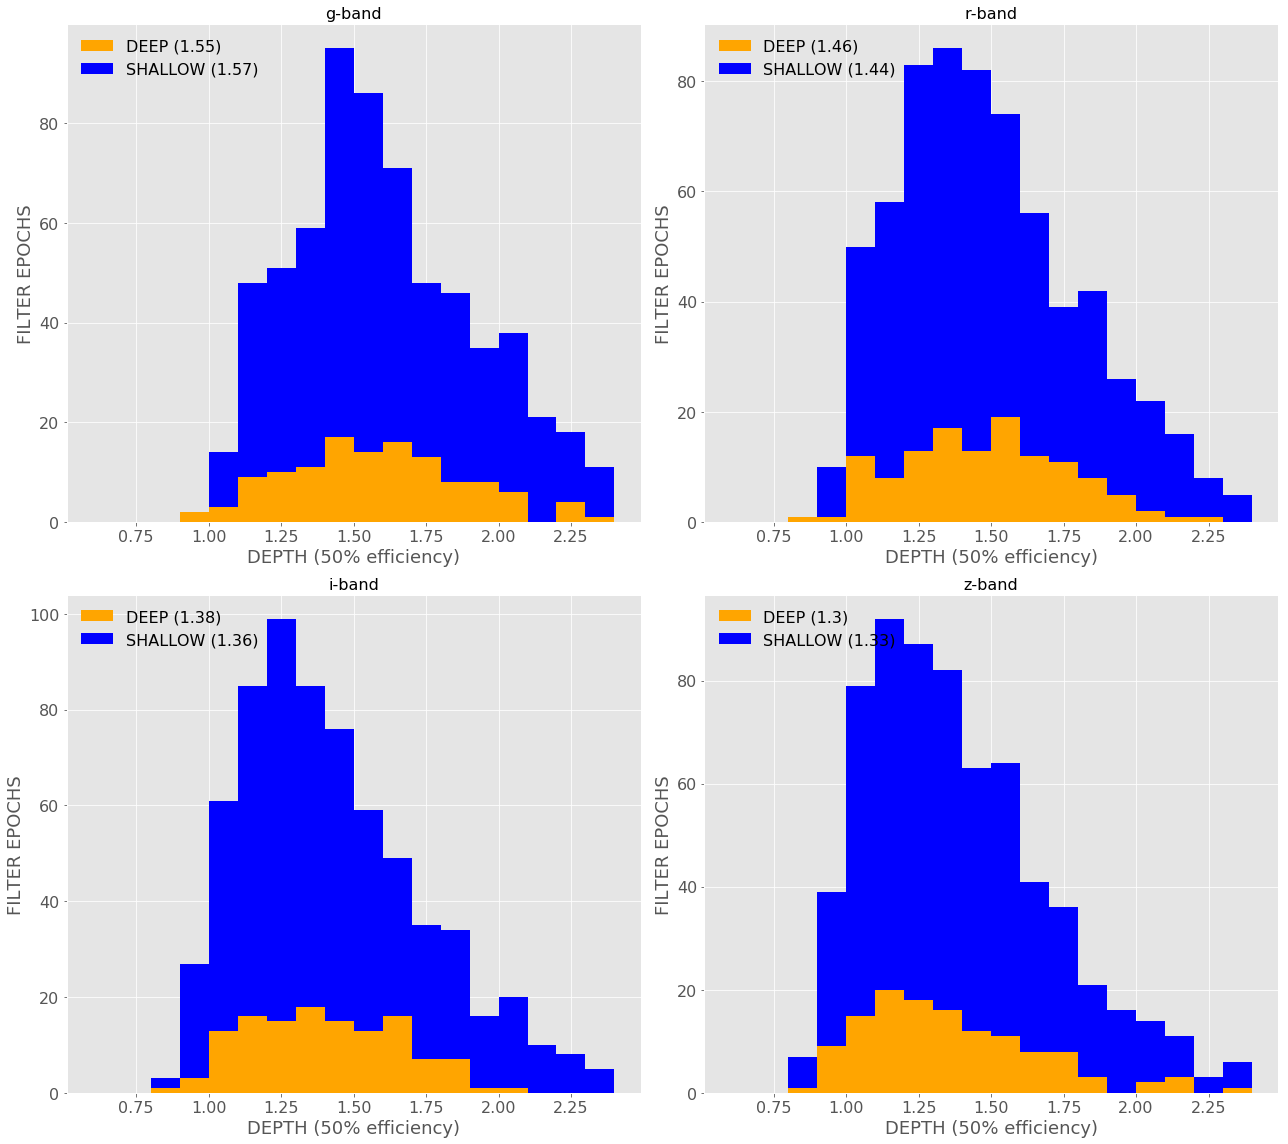

In [59]:
#PLOT FOR PAPER:  Seeing for each sequence, from COADD, from SN_STATUS page
f, ax1 = plt.subplots(2,2, figsize=(18,16))
ax2 = ax1.flatten()

band = ['g', 'r', 'i', 'z']

for i,ax in enumerate(ax2):
    flt = band[i]
    
    t1 = shallow.query("BAND == '{0}'".format(flt))
    t2 = deep.query("BAND == '{0}'".format(flt))
    
    ax.hist([t2['PSF'], t1['PSF']], \
            bins=np.arange(0.6,2.5,0.1), color=['orange','blue'], \
            label=['DEEP ({0})'.format(t2['PSF'].median()),'SHALLOW ({0})'.format(t1['PSF'].median())], \
            stacked='True', width=0.1) 

    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.set_ylabel('FILTER EPOCHS',fontsize=18)
    ax.set_xlabel('DEPTH (50% efficiency)',fontsize=18)

    ax.legend(loc='upper left',frameon=False,fontsize=16)
    ax.set_title('{0}-band'.format(flt),fontsize=16)

plt.tight_layout()
plt.show()

In [60]:
#Now read in the PER EXPOSURE table
filename = os.environ['HOME'] + '/Dropbox/DES/Papers/DAndrea2016/data/DESOPS/SN_TABLE_EVAL.txt' 

newqual = pd.read_csv(filename, sep=" ", header=None, skiprows=1)
newqual.columns = ['ID','NITE','FIELD','BAND','PROCESS','PATH',
                                     'FWHM','SKY','ELLIPT','T_EFF']
newqual = newqual.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [61]:
print len(newqual)
newqual = newqual.query("NITE > 20130606 and NITE < 20160606")
print len(newqual)

10508
6877


In [62]:
#PLOT FOR PAPER:  Seeing of each exposure from SN_TABLE_EVAL
data = pd.merge(newqual, new_data, how='left', \
                   on=['NITE','FIELD','BAND'], suffixes=('_exp','_epoch'))
print 'Length of all entries: ',len(data)



Length of all entries:  6877


In [63]:
print len(new_data)

3179


In [64]:
#Number of individual Filter-Field Epochs in the EXPOSURE table
t = newqual.groupby(['NITE','FIELD','BAND']).size()
print len(t)

3423


In [65]:
data.columns

Index([u'ID', u'NITE', u'FIELD', u'BAND', u'PROCESS', u'PATH', u'FWHM', u'SKY',
       u'ELLIPT', u'T_EFF', u'a', u'ATT', u'EXPNUM', u'STATUS', u'PSF', u'AIR',
       u'FAKE', u'zPSF', u'SNR20', u'EFF50', u'ACCEPT'],
      dtype='object')

In [66]:
#Select that ones that are good quality
good = data.query("ACCEPT == 'True'")
bad  = data.query("ACCEPT != 'True'")

print len(good)
print len(bad)

5485
1392


In [67]:
t = good.groupby(['NITE','FIELD','BAND']).size()
print len(t)

2663


In [68]:
#So we have good quality matched data for everything

In [69]:
#Remove those epochs where the FWHM is null (i.e., the exposure is poor though the sequence is good)
good = good[~good['FWHM'].isnull()]

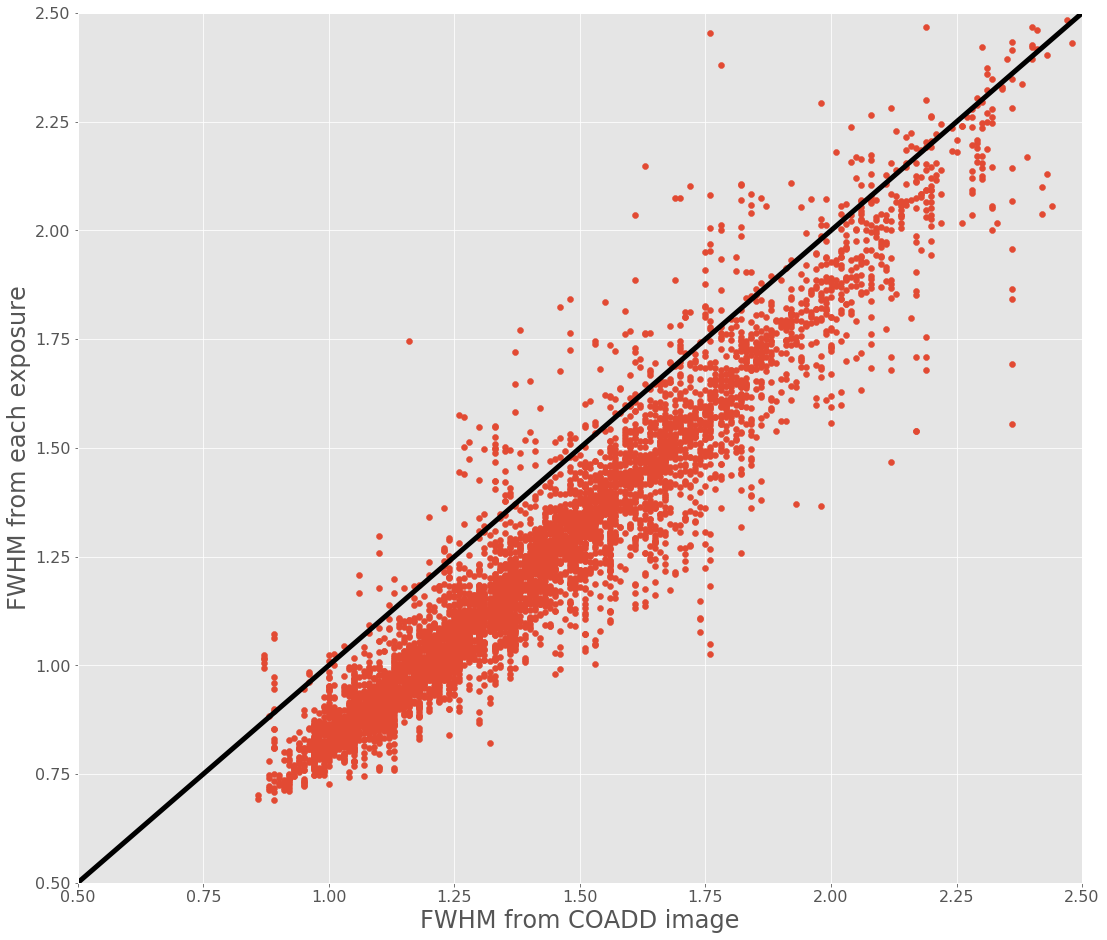

In [70]:
f, ax = plt.subplots(1, figsize=(18,16))

band   = ['g', 'r', 'i', 'z']
colors = ['mediumorchid','green','orange','saddlebrown']

ax.scatter(good['PSF'],good['FWHM'])
ax.plot(np.linspace(0,3,100),np.linspace(0,3,100),color='black')

#for i,item in enumerate(band):
#    flt = item
#    t1 = data.query("BAND == '{0}'".format(flt))
#    ax.scatter(t1['FWHM'], t1['PSF'], color=colors[i], label = "{0}-band".format(flt))

ax.set_xlabel('FWHM from COADD image', fontsize=24)
ax.set_ylabel('FWHM from each exposure',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_xlim(0.5,2.5)
ax.set_ylim(0.5,2.5)
plt.show()

In [71]:
band = ['g', 'r', 'i', 'z']
for j, item in enumerate(band):
    print '--------------{}------------'.format(item)
    t1 = good.query("BAND == '{0}'".format(item))
    print 'MEDIAN: ',np.median(t1['EFF50']),np.median(t1['PSF']),np.median(t1['FWHM'])
        
    

--------------g------------
MEDIAN:  24.1 1.57 1.4215
--------------r------------
MEDIAN:  24.0 1.45 1.288
--------------i------------
MEDIAN:  24.0 1.37 1.174
--------------z------------
MEDIAN:  24.0 1.3 1.091


3.179 3.17
2.697 2.381
2.461 2.881
2.373 2.892


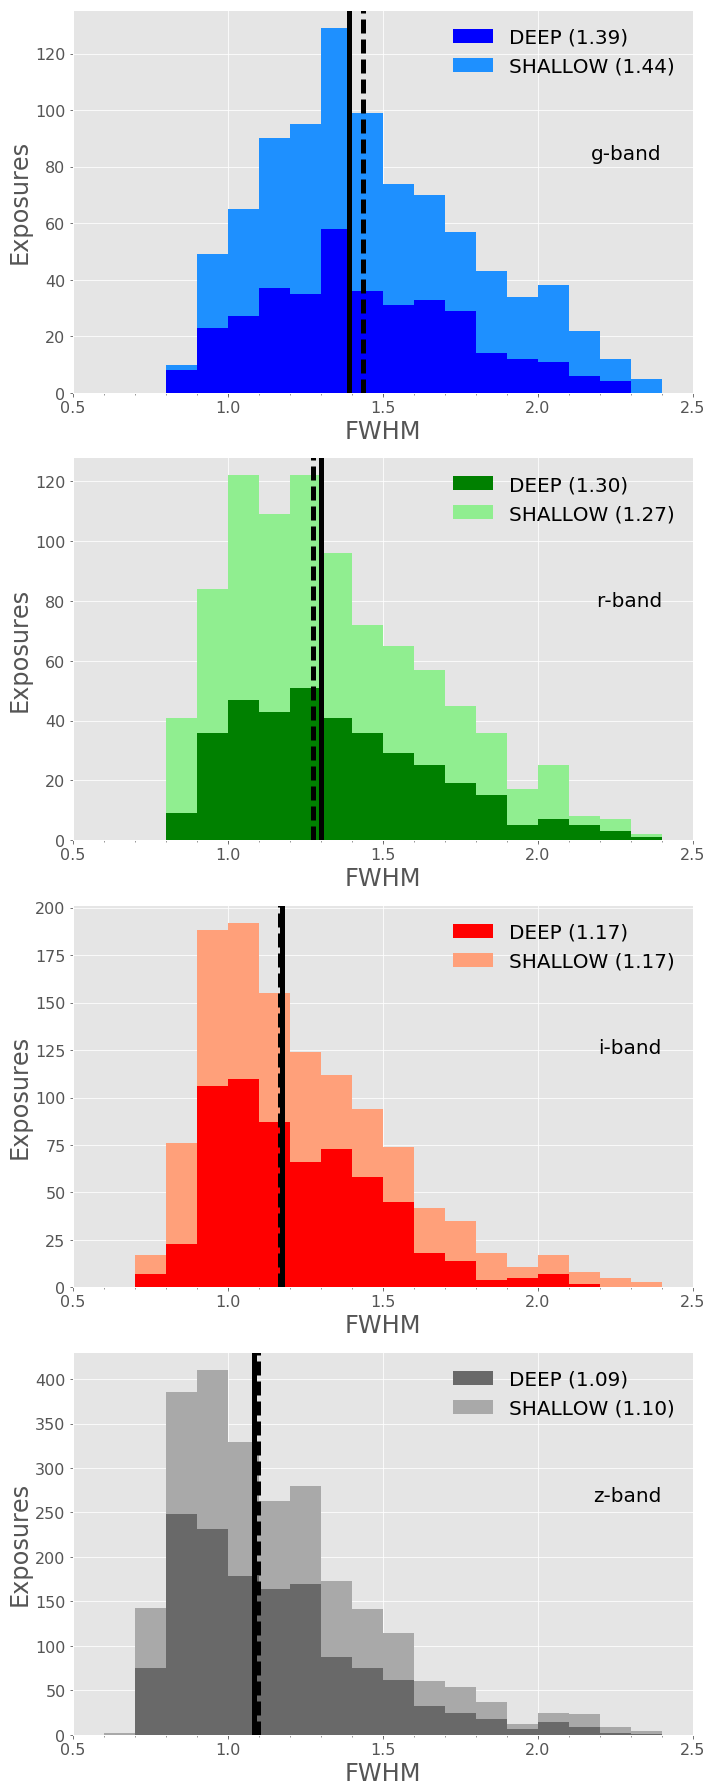

In [72]:
#PLOT FOR PAPER:  Histogram of Depth by field
f, ax1 = plt.subplots(4,1, figsize=(10,25))
ax2 = ax1.flatten()
mpl.style.use('ggplot')

#t2 = new_data.query("ACCEPT == 'True'")
#print len(t2)
deep    = good.query("FIELD == 'SN-X3' or FIELD == 'SN-C3'")
shallow = good.query("FIELD != 'SN-X3' and FIELD != 'SN-C3'")

color1  = ['blue', 'green', 'red', 'dimgrey']
color2  = ['dodgerblue', 'lightgreen', 'lightsalmon', 'darkgrey']
band = ['g', 'r', 'i', 'z']

for i,ax in enumerate(ax2):
    flt = band[i]
    
    t1 = shallow.query("BAND == '{0}'".format(flt))
    t2 = deep.query("BAND == '{0}'".format(flt))
    print max(t1['FWHM']),max(t2['FWHM'])
    
    ax.hist([t2['FWHM'], t1['FWHM']], \
            bins=np.arange(0.5,2.5,0.1), color=[color1[i],color2[i]], \
            label=['DEEP ({0:3.2f})'.format(t2['FWHM'].median()),'SHALLOW ({0:3.2f})'.format(t1['FWHM'].median())], \
            stacked='True', width=0.1)   
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.set_xlabel('FWHM', fontsize=24)
    ax.set_ylabel('Exposures', fontsize=24)
    
    aa = ax.get_ylim()
    ax.plot(t2['FWHM'].median()*np.ones(100), np.linspace(aa[0],aa[1],100), linestyle='solid', color='black')
    ax.plot(t1['FWHM'].median()*np.ones(100), np.linspace(aa[0],aa[1],100), linestyle='dashed', color='black')
    ax.set_ylim(aa)
        
    ax.set_xlim(0.5,2.5)
            
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))       
        
    ax.legend(loc='upper right',frameon=False,fontsize=20)
    ax.text(0.95,0.65,'{0}-band'.format(flt),fontsize=20,ha='right',va='top',transform = ax.transAxes)
    
#f.savefig('DES-SN3_DepthHist.pdf', format='pdf', bbox_inches='tight')
#plt.close()

plt.tight_layout()
plt.show()

g
r
i
z


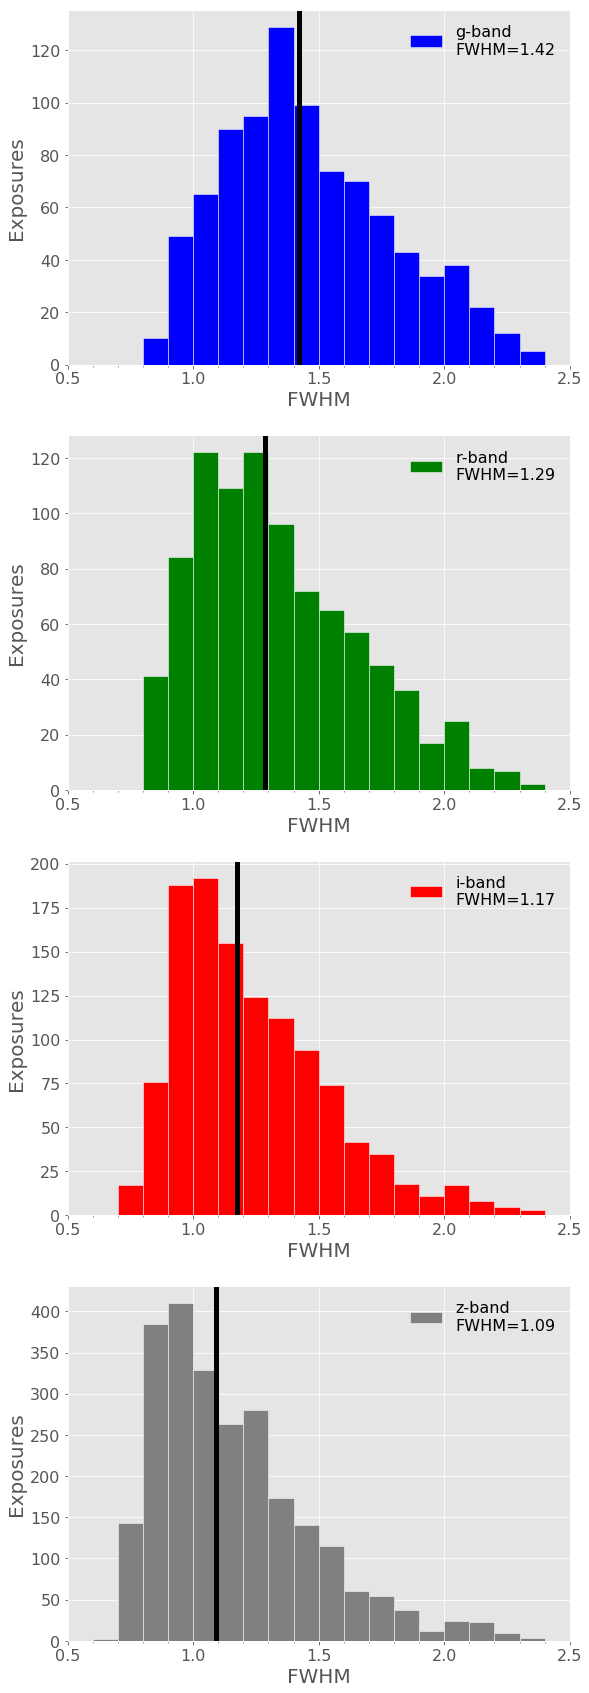

In [73]:
f, ax = plt.subplots(4,1, figsize=(9,30))

bands  = ['g','r','i','z']
color  = ['blue', 'green', 'red', 'grey']
for i in range(4):

        print bands[i]
        string = "BAND == '{0}' and FWHM > 0.1".format(bands[i])
        temp = good.query(string)
        
        FWHM = np.median(temp['FWHM'])
        sFWHM = '{0:4.2f}'.format(FWHM)

        ax[i].hist(temp['FWHM'], bins=np.arange(0.5,2.5,0.1), color=color[i], edgecolor='white',  
                     label = bands[i]+'-band\nFWHM='+sFWHM)

        ax[i].set_xlabel('FWHM', fontsize='20')
        ax[i].set_ylabel('Exposures', fontsize='20')
        ax[i].tick_params(axis='both', which='major', labelsize=14)
        ax[i].legend(loc='upper right',frameon=False,fontsize=16)

        t = ax[i].get_ylim()
        ax[i].plot(FWHM*np.ones(100),np.linspace(t[0],t[1],100),color='black')
        ax[i].set_ylim(t)
        ax[i].set_xlim(0.5,2.5)
        
        ax[i].xaxis.set_major_locator(MultipleLocator(0.5))
        ax[i].xaxis.set_minor_locator(AutoMinorLocator(5))    
        ax[i].tick_params(axis='both', which='major', labelsize=16)

plt.show()
#f.savefig('DES-SN4_Seeing.pdf', format='pdf', bbox_inches='tight')

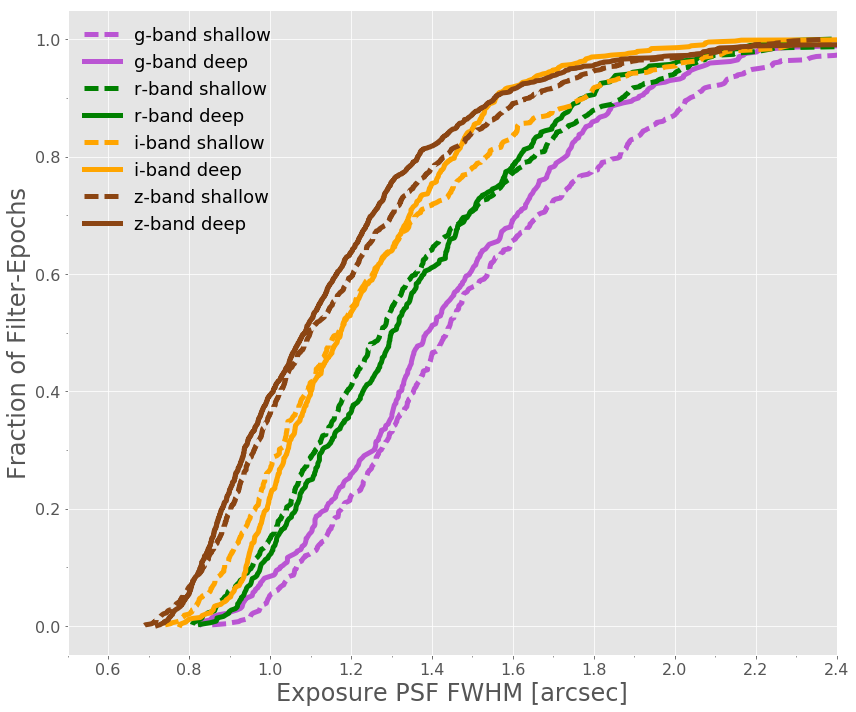

In [74]:
#PLOT FOR PAPER:  CDF of Depth by field
f, ax1 = plt.subplots(1, figsize=(12,10))

band   = ['g', 'r', 'i', 'z']
colors = ['mediumorchid','green','orange','saddlebrown']

mpl.rcParams['lines.linewidth'] = 5

deep    = good.query("FIELD == 'SN-X3' or FIELD == 'SN-C3'")
shallow = good.query("FIELD != 'SN-X3' and FIELD != 'SN-C3'")

for i,item in enumerate(band):
    flt = item
    
    t1 = shallow.query("BAND == '{0}'".format(flt))
    t2 = deep.query("BAND == '{0}'".format(flt))
    
    x1 = t1.sort_values(by='FWHM')
    y1 = 1.0+np.arange(1.0*len(x1))
    ax1.plot(x1['FWHM'],y1/len(x1),color=colors[i],linestyle='dashed',label = '{0}-band shallow'.format(flt))
        
    x2 = t2.sort_values(by='FWHM')
    y2 = 1.0+np.arange(1.0*len(x2))    
    ax1.plot(x2['FWHM'],y2/len(x2),color=colors[i],linestyle='solid',label = '{0}-band deep'.format(flt))
        
    ax1.xaxis.set_major_locator(MultipleLocator(0.2))
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))    
    ax1.yaxis.set_major_locator(MultipleLocator(0.2))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(2))    

    #ax1.grid(which='minor', axis='x', linestyle='--')
    ax1.grid(which='major', axis='xy', linestyle='-',linewidth=3)
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ax1.set_ylabel('Fraction of Filter-Epochs',fontsize=24)
    ax1.set_xlabel('Exposure PSF FWHM [arcsec]',fontsize=24)

    ax1.set_xlim(0.5,2.4)
    
    ax1.legend(loc='upper left',frameon=False,fontsize=18)
  
#f.savefig('DES-SN3_FWHMCDF.pdf', format='pdf', bbox_inches='tight')
#plt.close()
plt.tight_layout()
plt.show()

In [75]:
#Mean Cadence
len(t2)
t2 = new_data.query("ACCEPT == 'True'")

fields = ['SN-S1','SN-S2','SN-C1','SN-C2','SN-C3','SN-E1','SN-E2','SN-X1','SN-X2','SN-X3']
bands  = ['g','r','i','z']
dates = ['20130606','20140606','20150606','20160606','20170606']
cadence = []
flag = 0
for i in fields:
    for j in bands:
        for k in range(4):
            string = "BAND == '{1}'"
            temp = t2.query(string.format(i,j,dates[k],dates[k+1]))
            print i,j,k,len(temp)
            flag += len(temp)
            
            res = temp.sort_values(['MJD_OBS'])
            temp = res['MJD_OBS'].as_matrix()
            print temp
            
            for l in range(len(res)-1):
                val = temp[l+1]-temp[l]
                cadence.append(val)

SN-S1 g 0 663


KeyError: 'MJD_OBS'

In [77]:
t2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2663 entries, 1412 to 4915
Data columns (total 14 columns):
a         2663 non-null object
NITE      2663 non-null int64
FIELD     2663 non-null object
BAND      2663 non-null object
ATT       2663 non-null object
EXPNUM    2663 non-null int64
STATUS    2663 non-null object
PSF       2663 non-null float64
AIR       2663 non-null float64
FAKE      2663 non-null float64
zPSF      2663 non-null float64
SNR20     2663 non-null float64
EFF50     2663 non-null float64
ACCEPT    2663 non-null object
dtypes: float64(6), int64(2), object(6)
memory usage: 312.1+ KB


In [63]:
print len(cadence)
print flag

3621
3781


In [61]:
print len(t2.query("NITE_qual > 20130606 and NITE_qual < 20170606"))

4069


In [66]:
t2.BAND_qual.unique()

array(['g', 'r', 'i', 'z', nan], dtype=object)

In [67]:
print np.median(cadence)

6.97827465


In [68]:
print np.max(cadence)

26.95809841


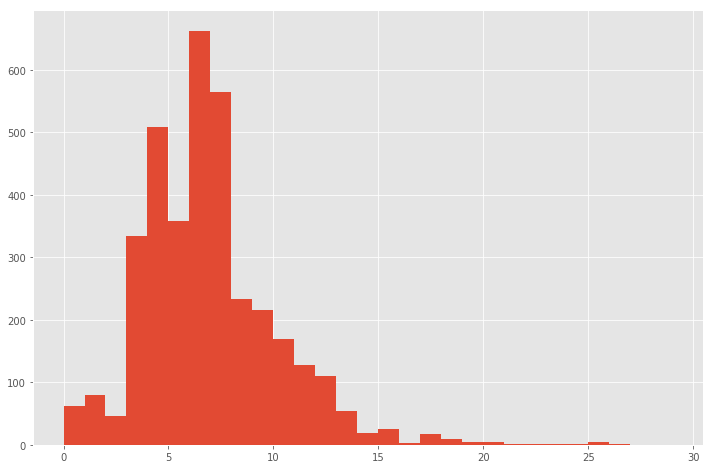

In [73]:
f, ax1 = plt.subplots(1, figsize=(12,8))

ax1 = plt.hist(cadence,bins=np.arange(0,30,1))

plt.show()

In [77]:
vv = np.sort(cadence)

In [79]:
print len(vv)

3621


In [82]:
print vv[1610]

6.89976345999


In [81]:
print vv[2000]

6.99512203


In [83]:
print np.mean(cadence)

7.04850988735


In [12]:
#See what the depth is in our DES-SN fields as a function of time
#matplotlib.style.use('ggplot')

fields = ['SN-S1','SN-S2','SN-C1','SN-C2','SN-C3','SN-E1','SN-E2','SN-X1','SN-X2','SN-X3']
f, ax1 = plt.subplots(1,10, figsize=(16,90))
mpl.style.use('ggplot')

ax2 = ax1.flatten()

for i,item in enumerate(ax2):
#Just select C3, Y4
    t = new_data.query("FIELD_qual == '{0}' and \
                        NITE_qual > 20160606 and NITE_qual < 20170606 and \
                        EFF50 < 28 and ACCEPT == 'True'".format(fields[i]) )
    t = t.sort_values(by='MJD_OBS')

    mpl.rcParams['lines.linewidth'] = 3

    ax1 = t.query("BAND_qual == 'g'").plot(x='MJD_OBS',y='EFF50',color='blue', ax=ax1, \
                                       label='g', marker='o', markersize='9')
    t.query("BAND_qual == 'r'").plot(x='MJD_OBS',y='EFF50',color='green', ax=ax1, label='r', \
                                marker='o', markersize='9')
    t.query("BAND_qual == 'i'").plot(x='MJD_OBS',y='EFF50',color='orange', ax=ax1, label='i', \
                                marker='o', markersize='9')
t.query("BAND_qual == 'z'").plot(x='MJD_OBS',y='EFF50',color='brown', ax=ax1, label='z', \
                                marker='o', markersize='9')

ax1.set_title('C3-Y4 Depth',fontsize=24)
ax1.set_ylim(26,22.5)
#t.plot(x='MJD_OBS',y='EFF50',color='green')
#t.plot(x='MJD_OBS',y='EFF50',color='orange')
#t.plot(x='MJD_OBS',y='EFF50',color='brown')
plt.show()



AttributeError: 'numpy.ndarray' object has no attribute 'get_figure'